In [1]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
import retro_prepare
import matplotlib.colors

In [2]:
patient_id = 'id001_bt'
data_dir = f'/home/hfw/Retro/datasets/{patient_id}'
results_dir = f'/home/hfw/Retro/results/{patient_id}'
#szr_name = 'BTcrise2appportable_0013'
szr_name = 'BTcrise1appportable_0006'
meta_data_fname = f'{szr_name}.json'
#raw_seeg_fname = f'{szr_name}.raw.fif'
fname_suffix = f'{szr_name}'
# if os.path.isdir(results_dir):
#     os.rmdir(results_dir)
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)
os.makedirs(f'{results_dir}/Rfiles', exist_ok=True)

In [3]:
hpf = 10
lpf = 0.02
raw_seeg_fname = f'{szr_name}.raw.fif'

#data_mono = retro_prepare_data.prepare_data(data_dir, meta_data_fname, raw_seeg_fname, szr_name, hpf, lpf)
#raw_seeg_fname = f'{szr_name}.bip.raw.fif'
#data = retro_prepare_data.prepare_data_bip(data_dir, meta_data_fname, raw_seeg_fname, szr_name, hpf, lpf)
#fname_suffix += f'_hpf{hpf}_lpf{lpf}'

In [7]:
seeg, bip = retro_prepare.read_one_seeg(data_dir, meta_data_fname, raw_seeg_fname)

Isotrak not found


ValueError: too many values to unpack (expected 2)

In [4]:
def read_ez_sens_mask(sid, ch_names):
    xlsx_file = os.path.join(sid, "patient.xlsx")
    CONTACTS_IND = 6
    EZ_IND = 7
    df = pd.read_excel(xlsx_file, sheet_name="EZ hypothesis and EI", header=1)
    ez_contacts = []
    contacts_col = df.iloc[:, CONTACTS_IND]
    mask = contacts_col.notnull()
    contacts_names = contacts_col[mask]
    ez_mask = df.iloc[:, EZ_IND][mask] == "YES"
    ez_contacts.extend(contacts_names[ez_mask])
    # OR1-OR2 -> OR1-2
    # TODO handle the case monopolar
    ez_contacts_ = []
    cre = re.compile("([A-Za-z'p]+)([0-9]+)-([A-Za-z'p]+)([0-9]+)")
    cre_mono = re.compile("([A-Za-z'p]+)([0-9]+)")
    for ez_contact in ez_contacts:
        try:
            nm, i, _, j = cre.match(ez_contact).groups()
            ez_contacts_.append(f"{nm}{i}-{j}")
        except Exception as exc:
            try:
                nm, i = cre_mono.match(ez_contact).groups()
                ez_contacts_.append(f"{nm}{i}-{int(i)+1}")
            except Exception as exc:
                print(sid, ez_contact, exc)
                continue
    m_ez = np.array([_ in ez_contacts_ for _ in ch_names])
    return m_ez

In [5]:
import mne
import pandas as pd
import re

In [4]:
raw = retro_prepare.load_raw_fif(meta_data_fname)
'''raw = mne.io.Raw(
                os.path.join(data_dir, 'seeg', 'fif', raw_seeg_fname),
                verbose='WARNING',
                preload=True)
#ezh = read_ez_sens_mask(data_dir, raw.ch_names)
'''

TypeError: string indices must be integers

In [7]:
bip_raw = retro_prepare_data.bipify_raw(raw)

In [9]:
len(bip_raw.ch_names)

100

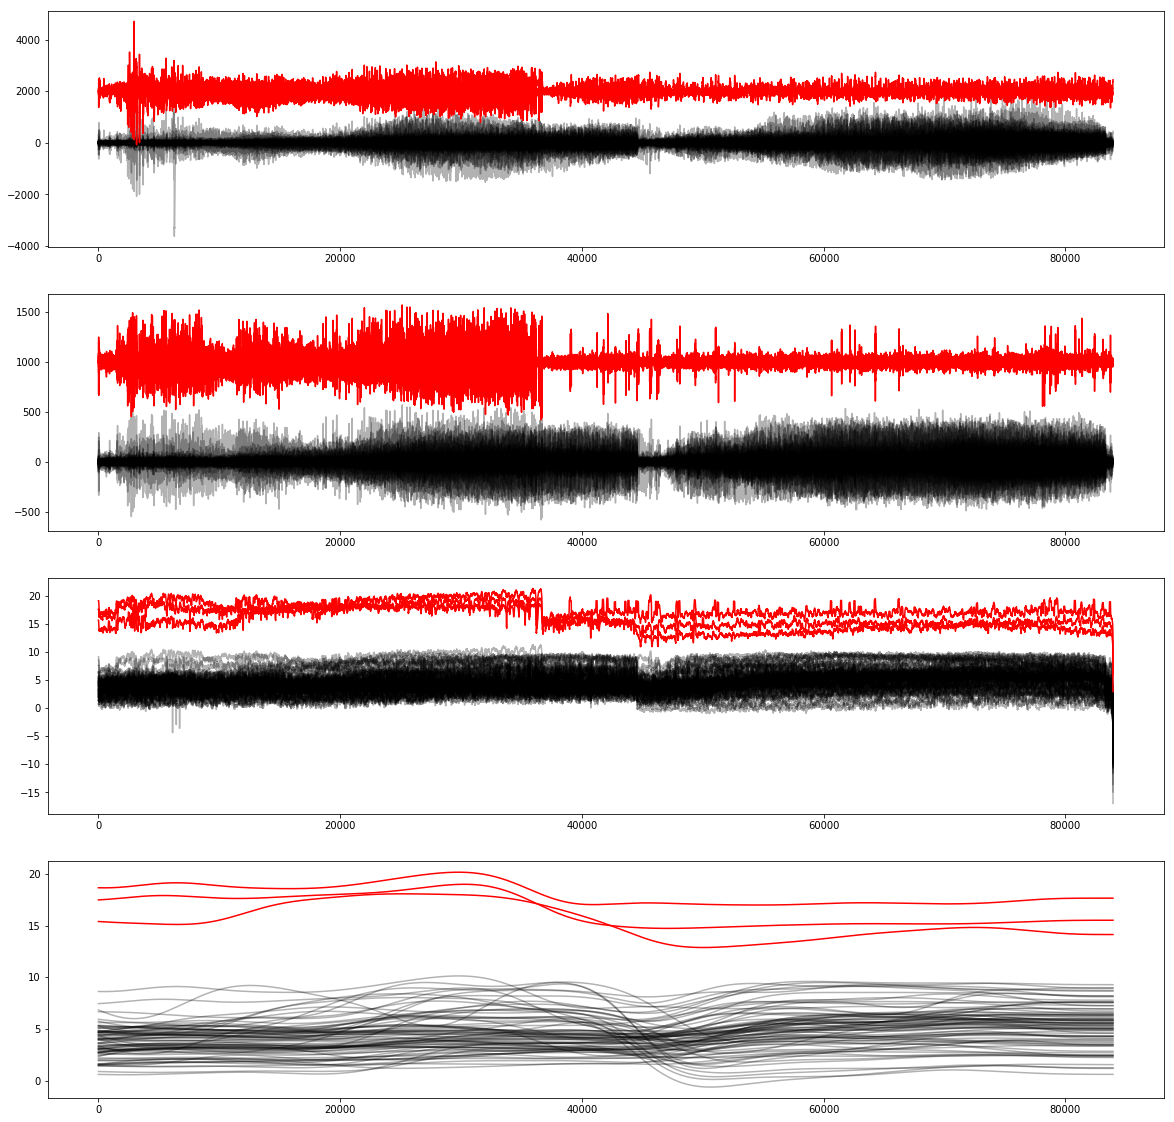

In [55]:
seeg = retro_prepare_data.read_one_bip_seeg(data_dir, meta_data_fname, raw_seeg_fname)
#start_idx = int(seeg['onset'] * seeg['sfreq']) - int(seeg['sfreq'])
#end_idx = int(seeg['offset'] * seeg['sfreq']) + int(seeg['sfreq'])
#slp = seeg['time_series'][start_idx:end_idx]
slp = seeg['time_series'].copy()
# Remove outliers i.e data > 2*sd
plt.figure(figsize=(20,20))
plt.subplot(411)
plt.plot(slp, color='black', alpha=0.3);
plt.plot(slp[:,ezh]+2000,color='red');

for i in range(slp.shape[1]):
    ts = slp[:, i]
    ts[abs(ts - ts.mean()) > 2 * ts.std()] = ts.mean()
# High pass filter the data
slp = lib.preprocess.envelope.bfilt(
    slp, seeg['sfreq'], hpf, 'highpass', axis=0)
plt.subplot(412)
plt.plot(slp, color='black', alpha=0.3);
plt.plot(slp[:,ezh]+1000,color='red');

# Compute seeg log power
slp = lib.preprocess.envelope.seeg_log_power(slp, 100)
plt.subplot(413)
plt.plot(slp, color='black', alpha=0.3);
plt.plot(slp[:,ezh]+10,color='red');

# Remove outliers i.e data > 2*sd
for i in range(slp.shape[1]):
    ts = slp[:, i]
    ts[abs(ts - ts.mean()) > 2 * ts.std()] = ts.mean()
# Low pass filter the data to smooth
slp = lib.preprocess.envelope.bfilt(
    slp, seeg['sfreq'], lpf, 'lowpass', axis=0)

plt.subplot(414)
plt.plot(slp, color='black', alpha=0.3);
plt.plot(slp[:,ezh]+10,color='red');




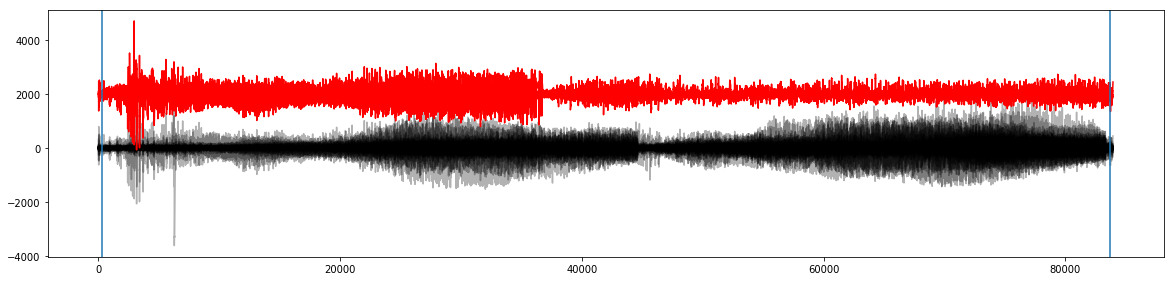

In [46]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(slp, color='black', alpha=0.3);
plt.plot(slp[:,ezh]+2000,color='red');
st_slp = int(seeg['sfreq'])
plt.axvline(st_slp)
plt.axvline(len(slp)-st_slp)

In [39]:
print((seeg['offset']-seeg['onset'])*seeg['sfreq'],end_idx-start_idx,np.shape(seeg['time_series']))



83927.80799999999 84440 (83929, 79)


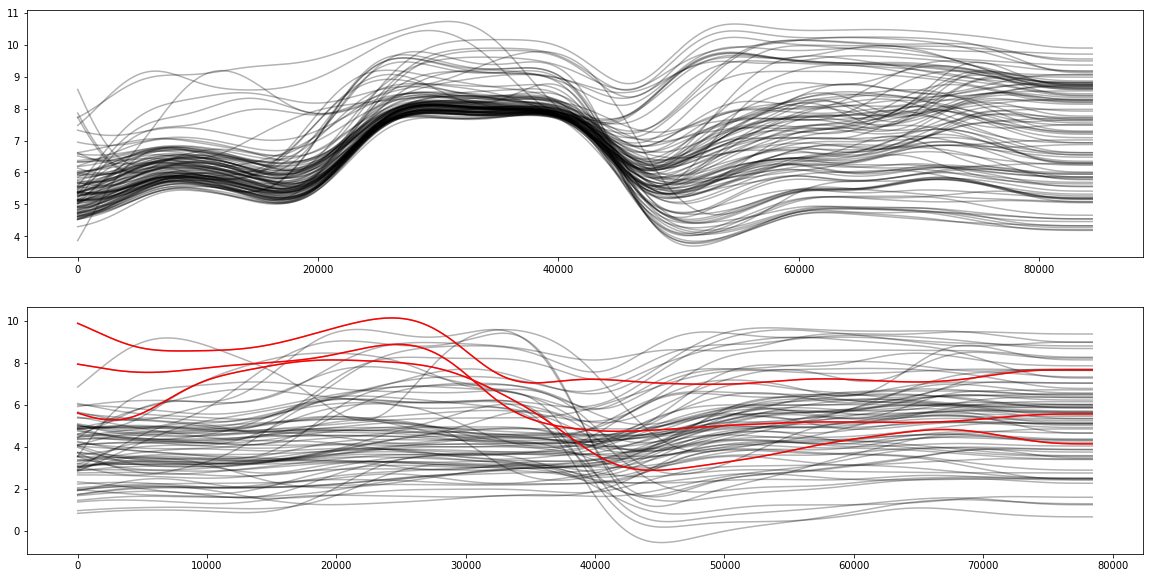

In [18]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(data_mono['slp'], color='black', alpha=0.3);
plt.subplot(212)
plt.plot(data['slp'], color='black', alpha=0.3);
plt.plot(data['slp'][:,ezh],color='red');

In [8]:
ds_freq = int(data['slp'].shape[0]/150)
data['slp'] = data['slp'][0:-1:ds_freq]
data['snsr_pwr'] = (data['slp']**2).mean(axis=0)
data['ns'], data['nn'] = data['gain'].shape
data['nt'] = data['slp'].shape[0]
ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.vep.txt') == 1)[0]
data['x0_mu'] = -3.0*np.ones(data['nn'])
data['x0_mu'][ez_hyp] = -1.5

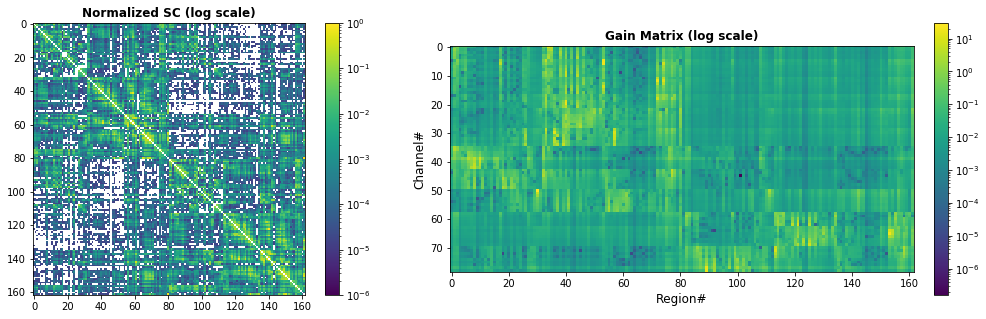

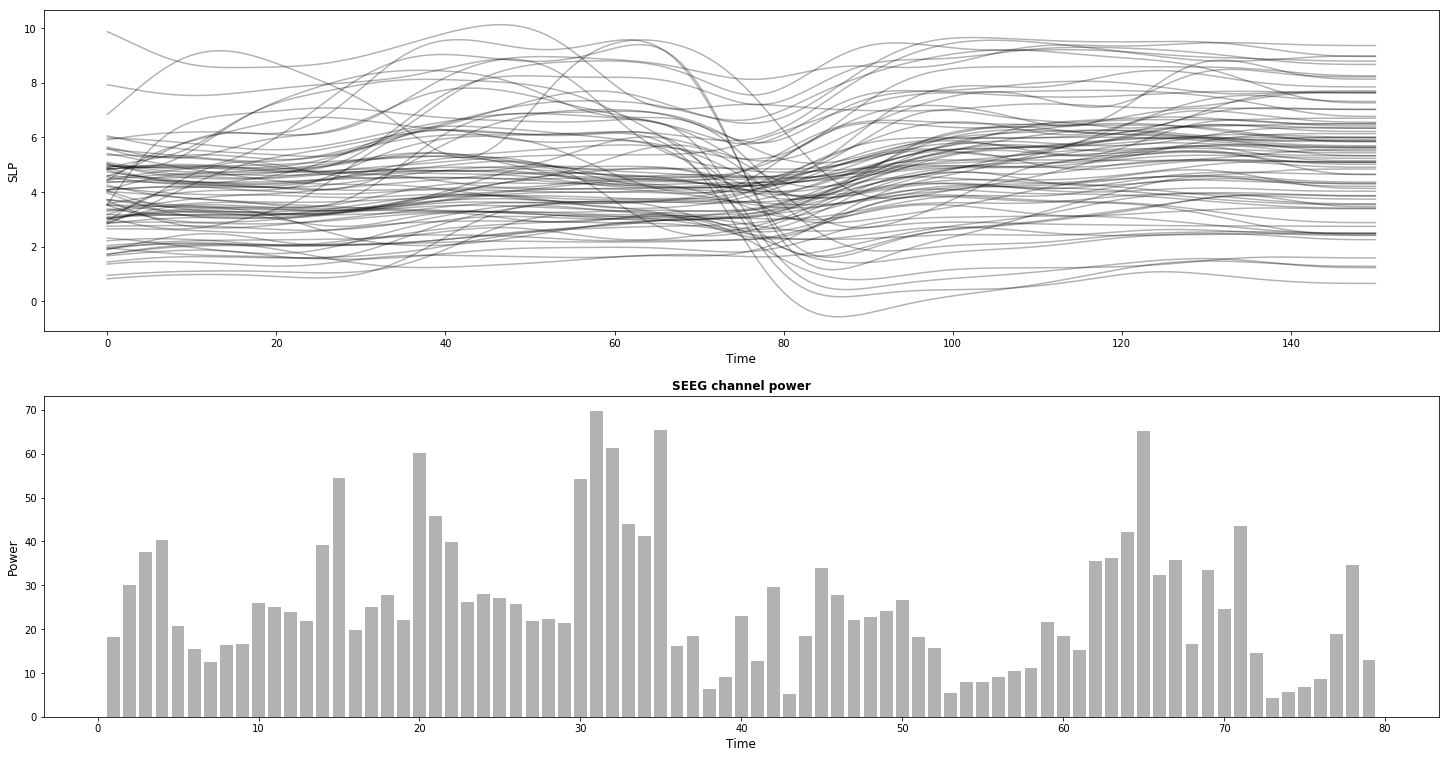

In [10]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(data['SC'],norm=matplotlib.colors.LogNorm(vmin=1e-6, vmax=data['SC'].max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.title('Normalized SC (log scale)',fontsize=12, fontweight='bold')

plt.subplot(122)
plt.imshow(data['gain'],norm=matplotlib.colors.LogNorm(vmin=data['gain'].min(), vmax=data['gain'].max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.xlabel('Region#', fontsize=12)
plt.ylabel('Channel#', fontsize=12)
plt.title('Gain Matrix (log scale)',fontsize=12, fontweight='bold')
plt.savefig(f'{results_dir}/figures/network.png')

plt.figure(figsize=(25,13))
plt.subplot(211)
plt.plot(data['slp'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('SLP', fontsize=12)

plt.subplot(212)
plt.bar(np.r_[1:data['ns']+1],data['snsr_pwr'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title('SEEG channel power', fontweight='bold')
plt.savefig(f'{results_dir}/figures/fitting_target_{fname_suffix}.png')
# plt.tight_layout()


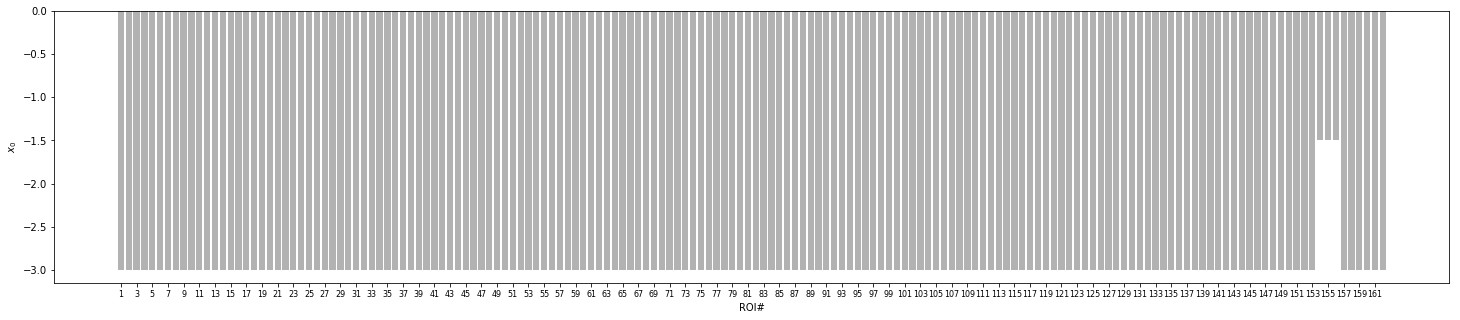

In [12]:
plt.figure(figsize=(25,5))
plt.bar(np.r_[1:data['nn']+1],data['x0_mu'], color='black', alpha=0.3)
plt.xticks(np.r_[1:data['nn']+1:2], fontsize=8);
plt.xlabel('ROI#')
plt.ylabel(r'$x_0$', fontsize=10)
plt.savefig(f'{results_dir}/figures/ez_hyp.png')

In [13]:
#stan_fname = 'vep-snsrfit-ode-nointerp'
stan_fname = 'szr_prpgtn'

x0 = data['x0_mu']
amplitude = 1.0 
offset = 0
K = 1.0
tau0 = 20
eps_slp = 1.0
eps_snsr_pwr = 1.0
x_init = -2.0*np.ones(data['nn'])
z_init = 3.5*np.ones(data['nn'])

param_init = {'x0':x0, 'amplitude':amplitude,
              'offset':offset, 'K':K, 'tau0':tau0, 'x_init':x_init, 'z_init':z_init,
              'eps_slp':eps_slp, 'eps_snsr_pwr':eps_snsr_pwr}

param_init_file = 'param_init.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/param_init.R',param_init)

input_Rfile = f'fit_data_{fname_suffix}.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}',data)

In [14]:
#%%bash -s "$stan_fname" 

#stancompile.sh $1

In [15]:
%%bash -s "$stan_fname" "$results_dir" "$input_Rfile" "$fname_suffix"

STAN_FNAME=$1
RESULTS_DIR=$2
INPUT_RFILE=$3
FNAME_SUFFIX=$4


for i in {1..4};
do
./${STAN_FNAME} optimize algorithm=lbfgs tol_param=1e-4 iter=20000 save_iterations=0  \
data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} \
init=${RESULTS_DIR}/Rfiles/param_init.R \
output file=${RESULTS_DIR}/samples_${FNAME_SUFFIX}_chain${i}.csv refresh=10 \
&> ${RESULTS_DIR}/logs/snsrfit_ode_${FNAME_SUFFIX}_chain${i}.log &
done

In [10]:
pstr_samples['tau0']

{'lp__': array([-24352.2]),
 'x0': array([[-2.97865 , -2.94068 , -2.99398 , -2.36919 , -2.98653 , -2.97743 ,
         -2.98842 , -2.99605 , -3.0763  , -2.99962 , -2.98212 , -2.81876 ,
         -2.95932 , -2.89444 , -2.7279  , -2.93403 , -2.83153 , -2.83034 ,
         -2.87092 , -2.97627 , -2.77074 , -2.93324 , -2.85186 , -2.74736 ,
         -2.71829 , -1.78575 , -2.92831 , -2.77145 , -2.71461 , -2.99759 ,
         -2.97351 , -2.99675 , -2.64702 , -1.88477 , -2.70958 , -2.54506 ,
         -2.26351 , -1.88757 , -2.98095 , -2.98566 , -2.8443  , -2.95401 ,
         -2.22759 , -2.97625 , -2.74827 , -3.01084 , -2.96576 , -2.69345 ,
         -2.85911 , -2.6549  , -2.98668 , -2.88864 , -2.98245 , -2.88715 ,
         -2.97985 , -2.93149 , -2.98147 , -2.9846  , -2.96661 , -2.9239  ,
         -2.91983 , -2.99174 , -2.97705 , -2.92948 , -2.98538 , -3.1727  ,
         -2.80611 , -2.70482 , -2.90362 , -2.99147 , -3.04242 , -2.5983  ,
         -0.379332, -2.66301 , -2.53325 , -2.92859 , -2.92557 , -2

In [14]:
pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain1.csv'])

print(pstr_samples['x0'],pstr_samples['tau0'])

[[-2.97865  -2.94068  -2.99398  -2.36919  -2.98653  -2.97743  -2.98842
  -2.99605  -3.0763   -2.99962  -2.98212  -2.81876  -2.95932  -2.89444
  -2.7279   -2.93403  -2.83153  -2.83034  -2.87092  -2.97627  -2.77074
  -2.93324  -2.85186  -2.74736  -2.71829  -1.78575  -2.92831  -2.77145
  -2.71461  -2.99759  -2.97351  -2.99675  -2.64702  -1.88477  -2.70958
  -2.54506  -2.26351  -1.88757  -2.98095  -2.98566  -2.8443   -2.95401
  -2.22759  -2.97625  -2.74827  -3.01084  -2.96576  -2.69345  -2.85911
  -2.6549   -2.98668  -2.88864  -2.98245  -2.88715  -2.97985  -2.93149
  -2.98147  -2.9846   -2.96661  -2.9239   -2.91983  -2.99174  -2.97705
  -2.92948  -2.98538  -3.1727   -2.80611  -2.70482  -2.90362  -2.99147
  -3.04242  -2.5983   -0.379332 -2.66301  -2.53325  -2.92859  -2.92557
  -2.78765  -2.92612  -2.90766  -3.03194  -2.98813  -3.05832  -3.08113
  -3.22098  -3.07246  -3.27219  -3.31777  -3.01404  -3.00858  -3.00756
  -3.00349  -3.08206  -3.00209  -2.99236  -3.0113   -3.01656  -3.04269
  -3.0

In [11]:
chains = [1,2,3,4]
for i,chain_no in enumerate(chains):
    pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{chain_no}.csv'])

    print(pstr_samples['x0'],pstr_samples['tau0'])

[[-2.97865  -2.94068  -2.99398  -2.36919  -2.98653  -2.97743  -2.98842
  -2.99605  -3.0763   -2.99962  -2.98212  -2.81876  -2.95932  -2.89444
  -2.7279   -2.93403  -2.83153  -2.83034  -2.87092  -2.97627  -2.77074
  -2.93324  -2.85186  -2.74736  -2.71829  -1.78575  -2.92831  -2.77145
  -2.71461  -2.99759  -2.97351  -2.99675  -2.64702  -1.88477  -2.70958
  -2.54506  -2.26351  -1.88757  -2.98095  -2.98566  -2.8443   -2.95401
  -2.22759  -2.97625  -2.74827  -3.01084  -2.96576  -2.69345  -2.85911
  -2.6549   -2.98668  -2.88864  -2.98245  -2.88715  -2.97985  -2.93149
  -2.98147  -2.9846   -2.96661  -2.9239   -2.91983  -2.99174  -2.97705
  -2.92948  -2.98538  -3.1727   -2.80611  -2.70482  -2.90362  -2.99147
  -3.04242  -2.5983   -0.379332 -2.66301  -2.53325  -2.92859  -2.92557
  -2.78765  -2.92612  -2.90766  -3.03194  -2.98813  -3.05832  -3.08113
  -3.22098  -3.07246  -3.27219  -3.31777  -3.01404  -3.00858  -3.00756
  -3.00349  -3.08206  -3.00209  -2.99236  -3.0113   -3.01656  -3.04269
  -3.0

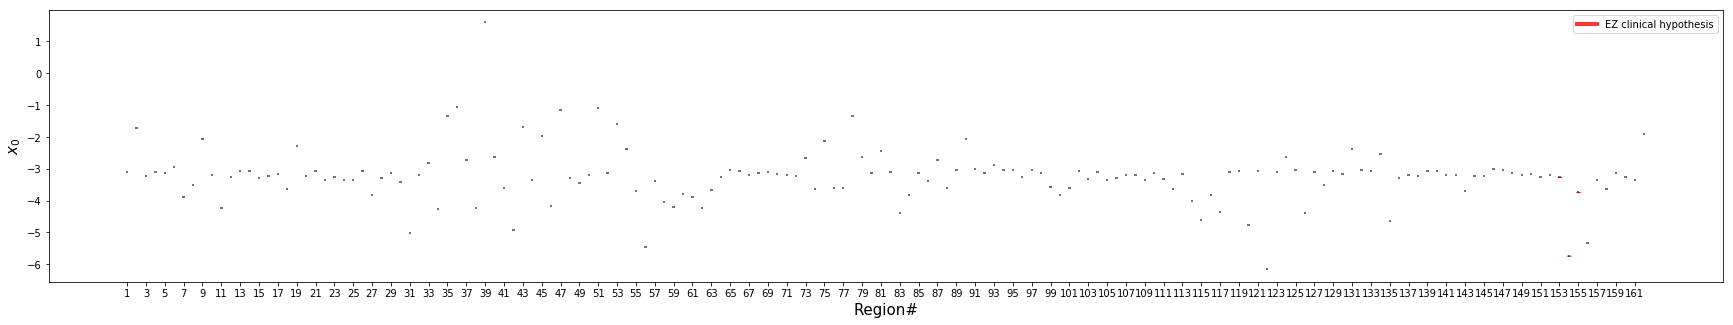

In [17]:
lib.plots.stan.x0_violin_patient(pstr_samples['x0'], ez_hyp, figsize=(30,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}_chain{chain_no}.png')

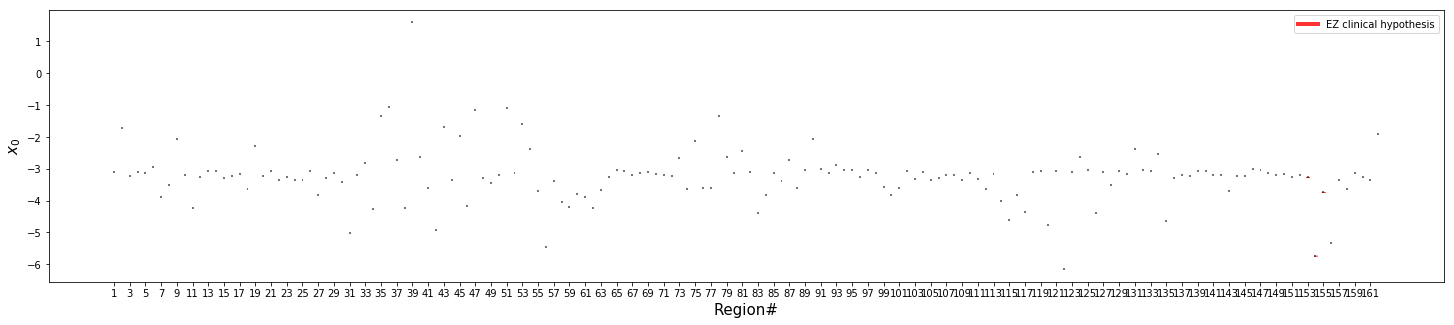

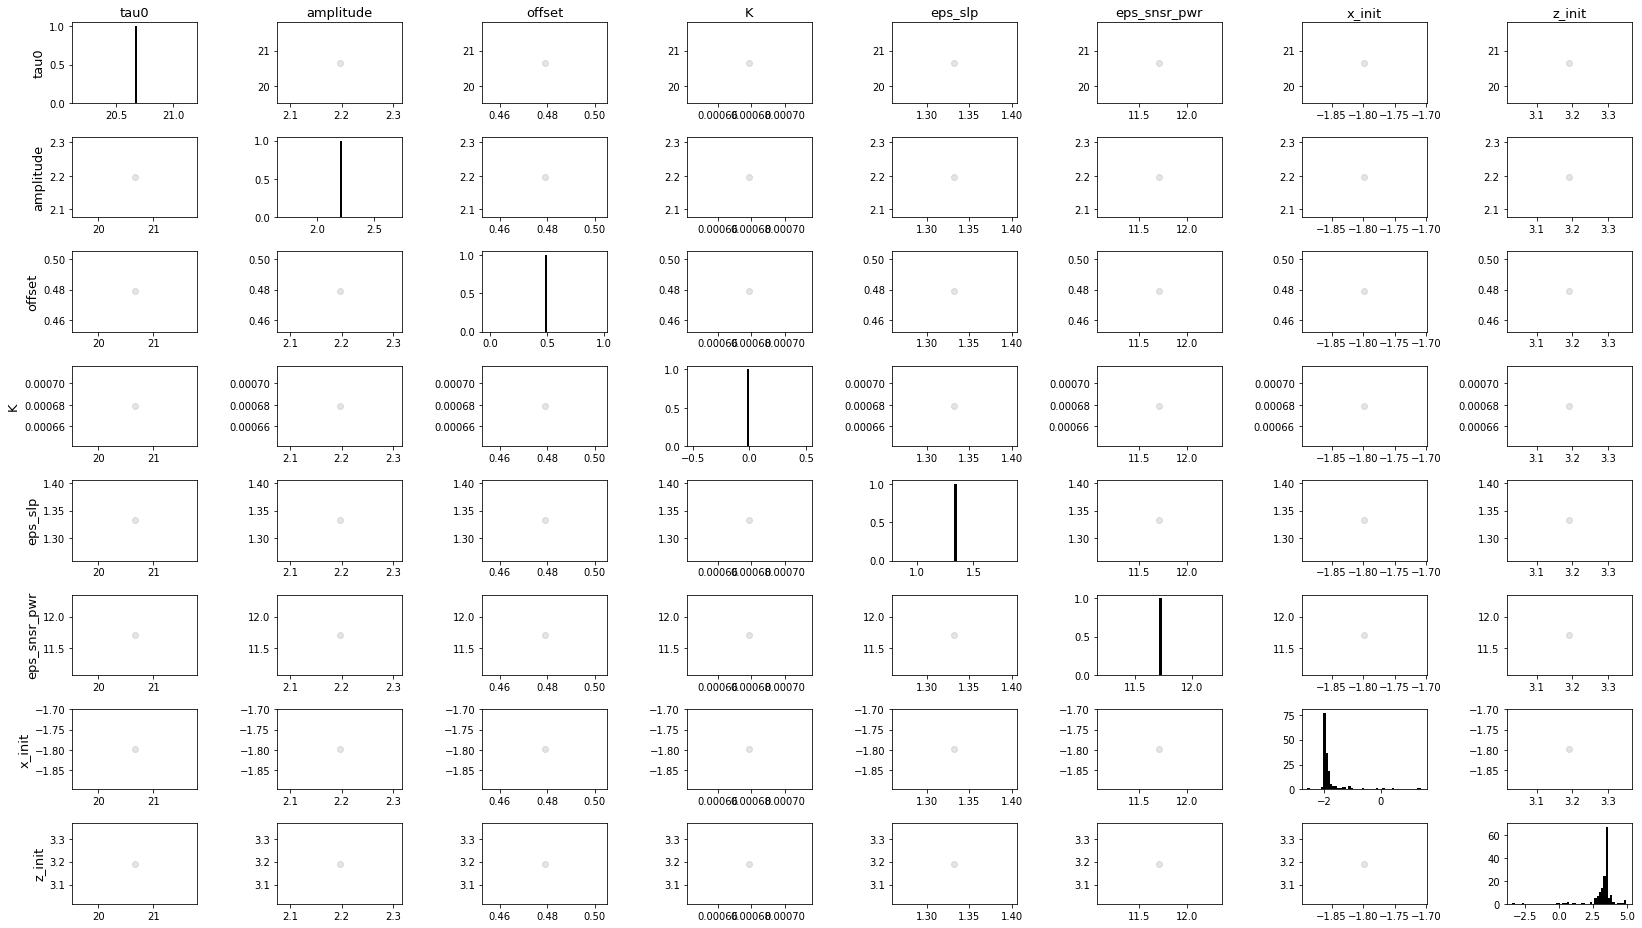

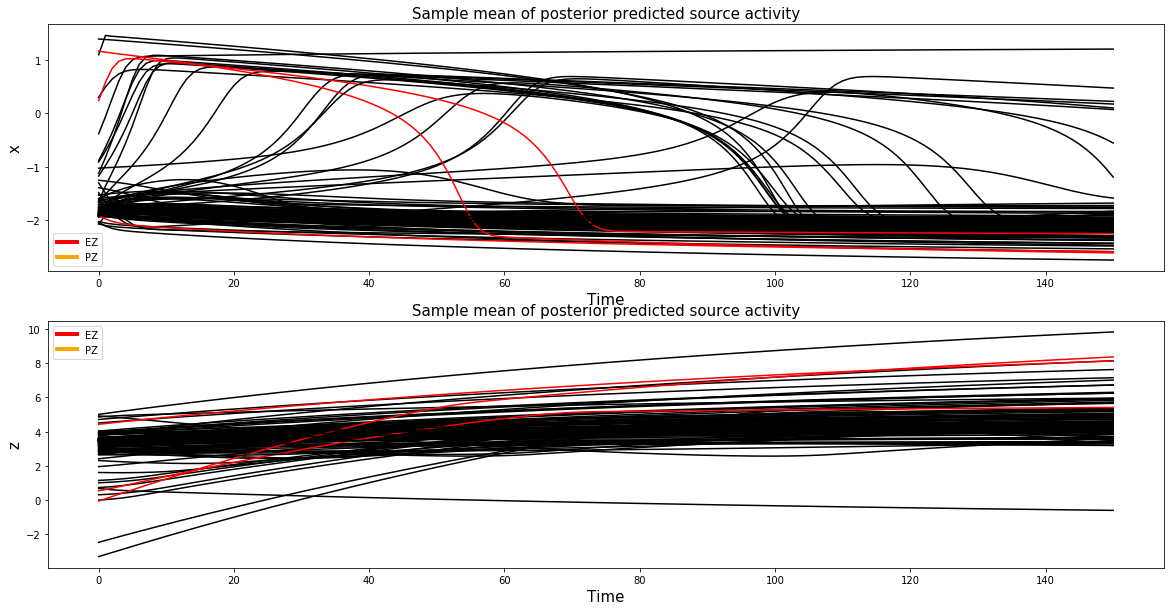

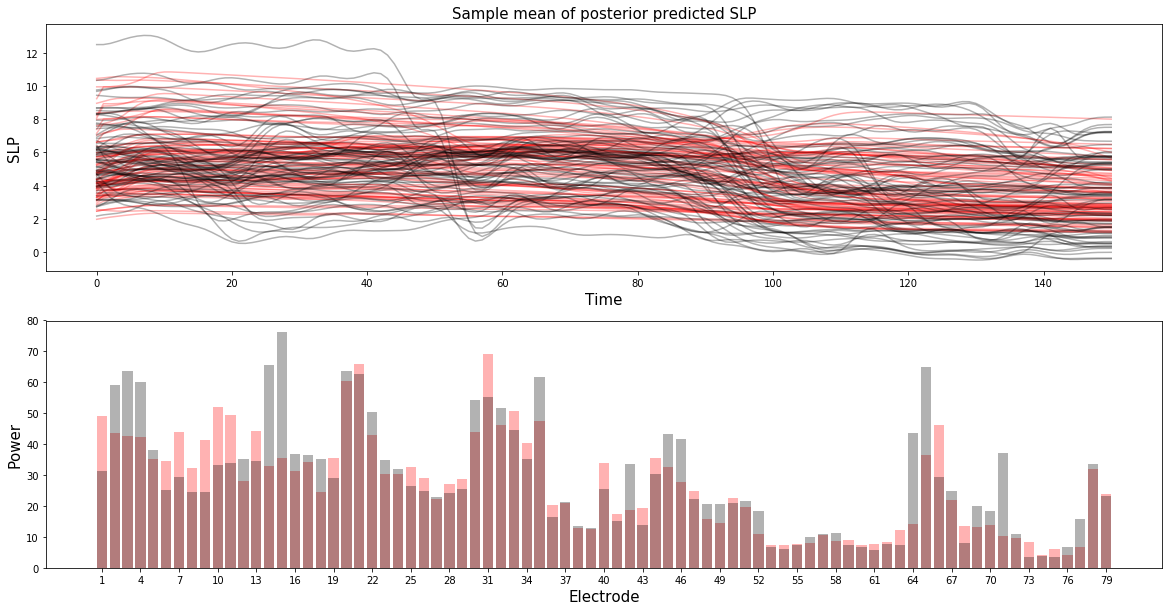

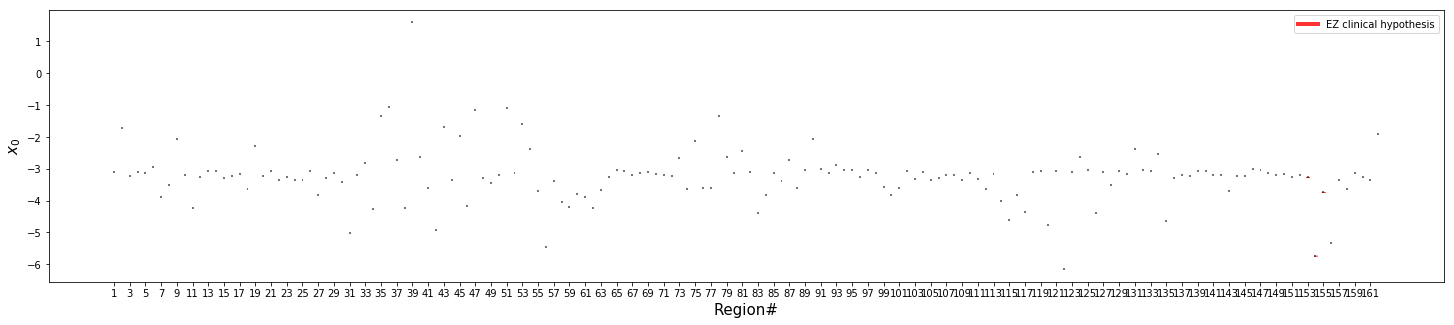

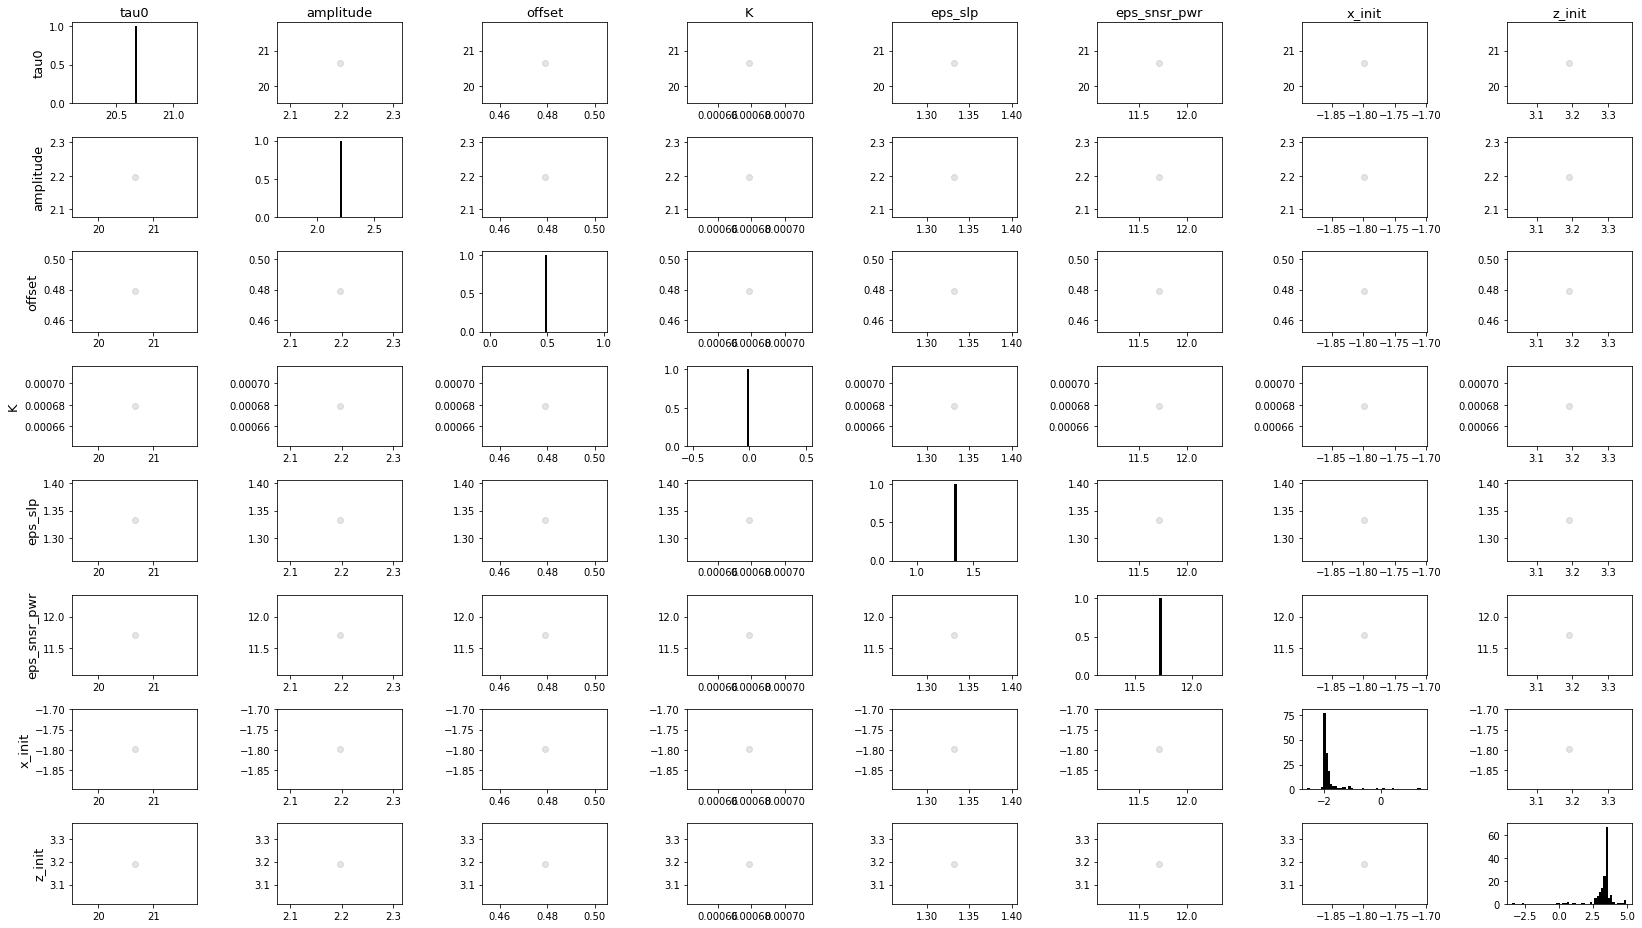

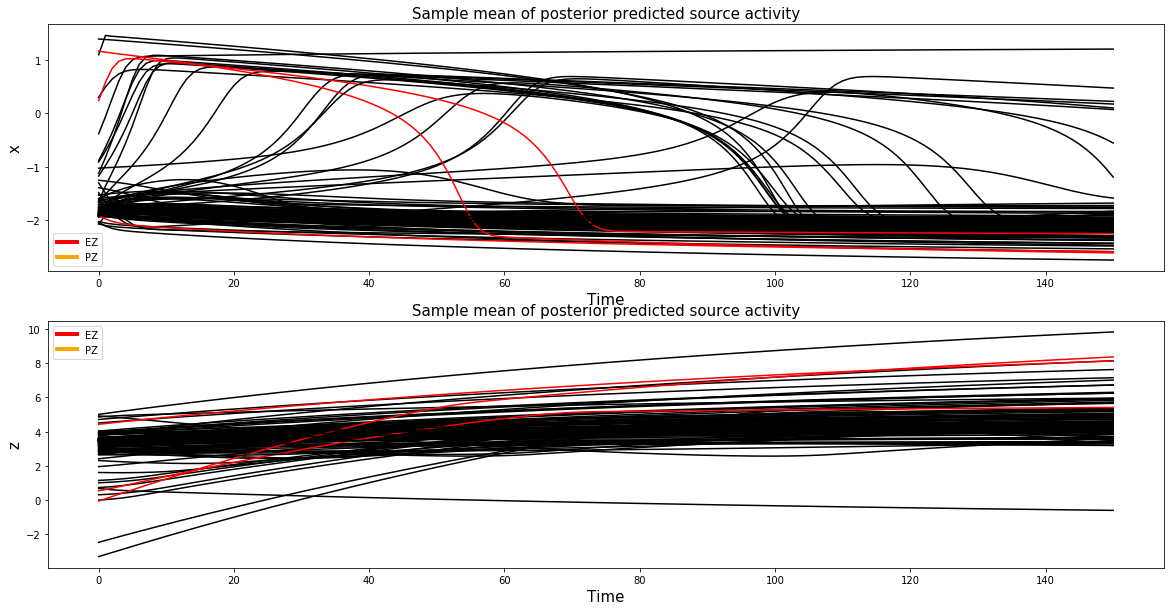

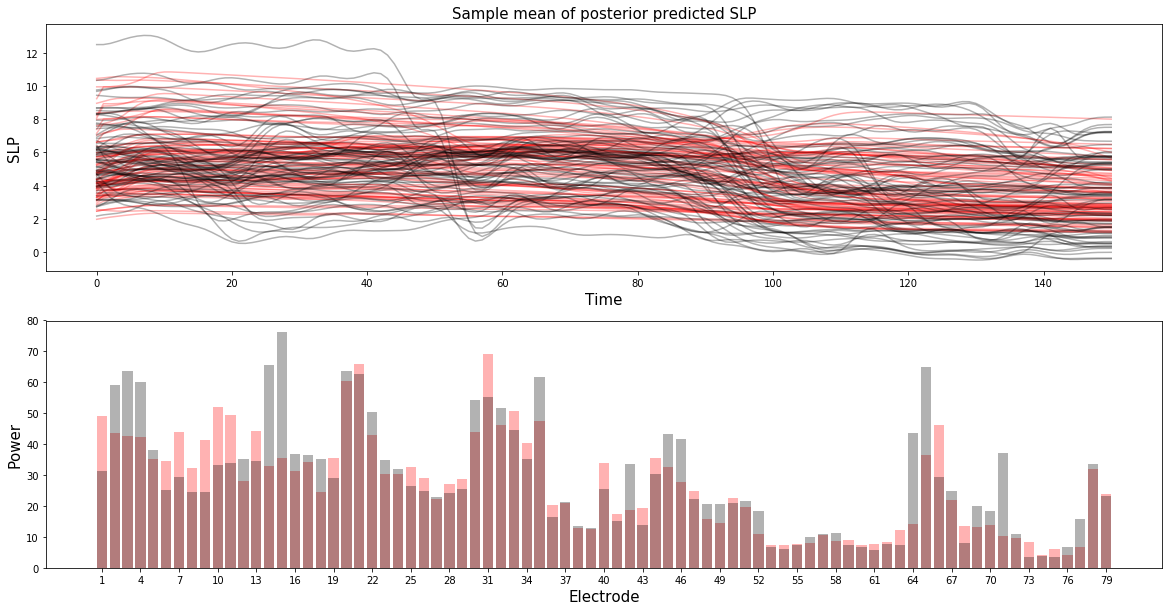

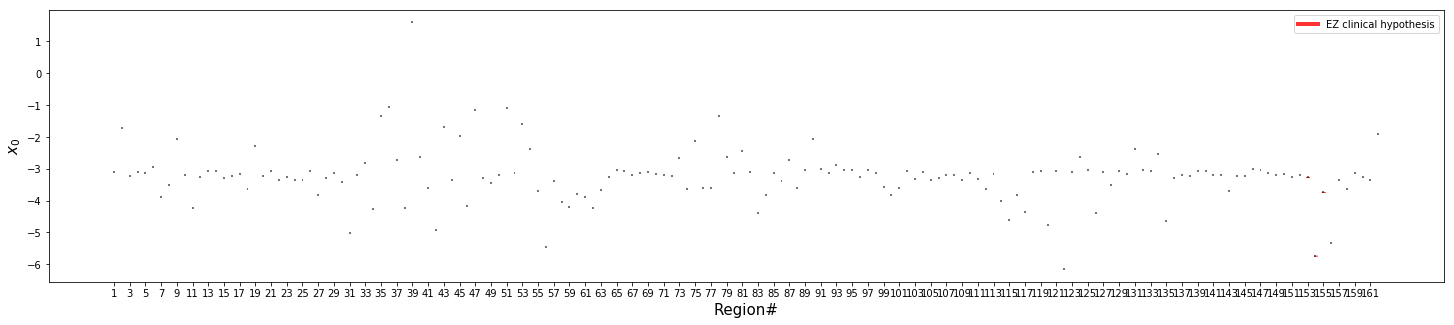

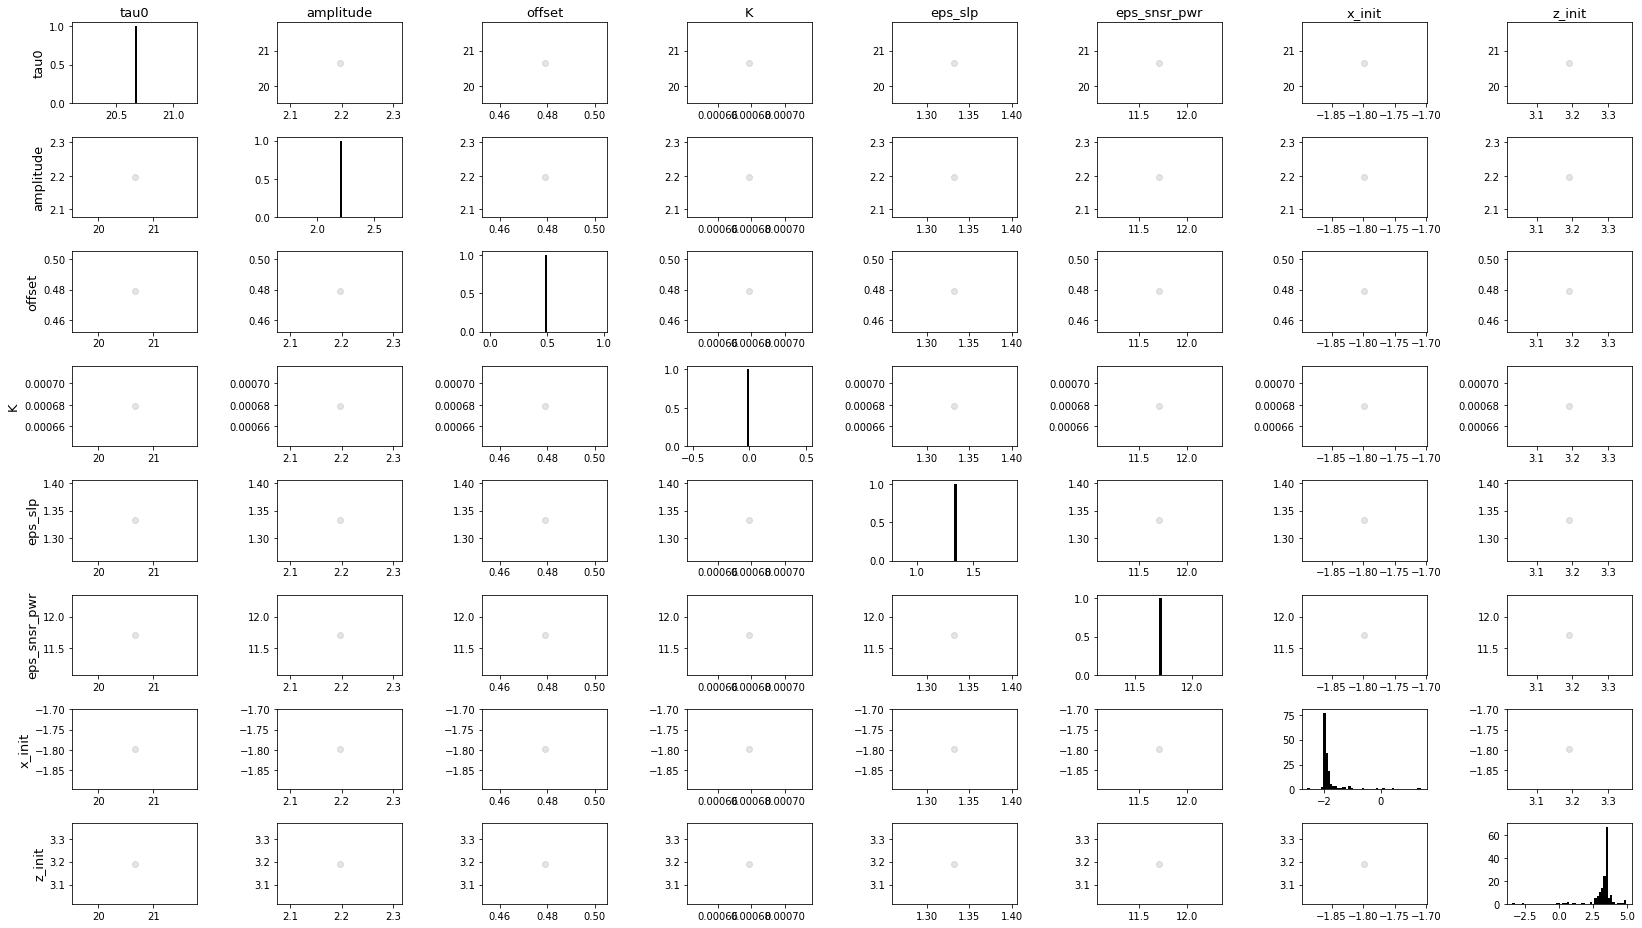

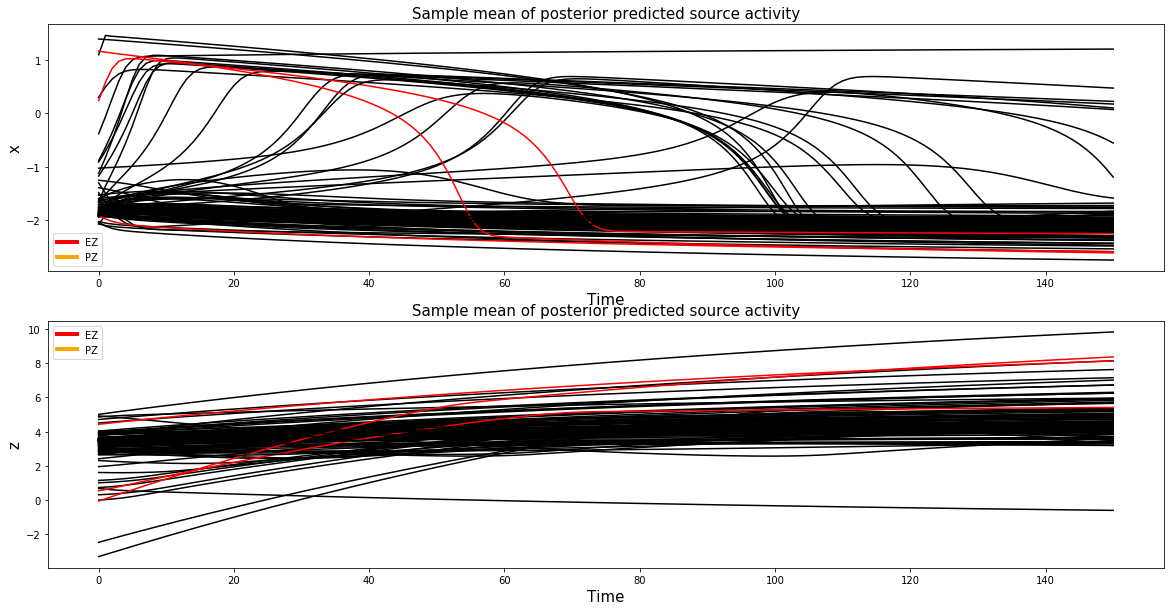

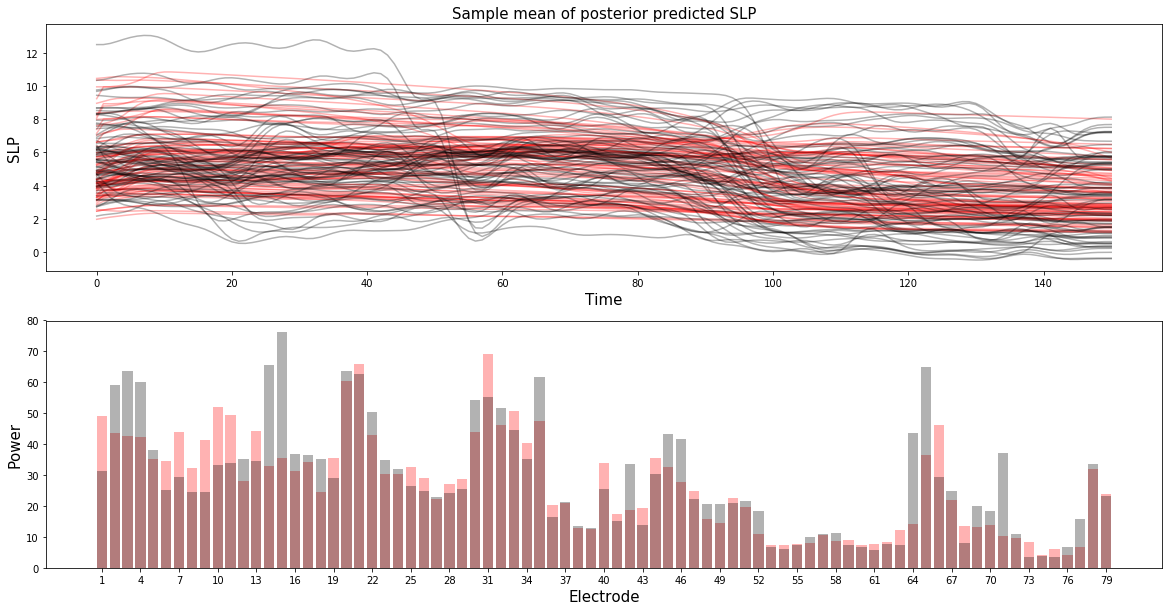

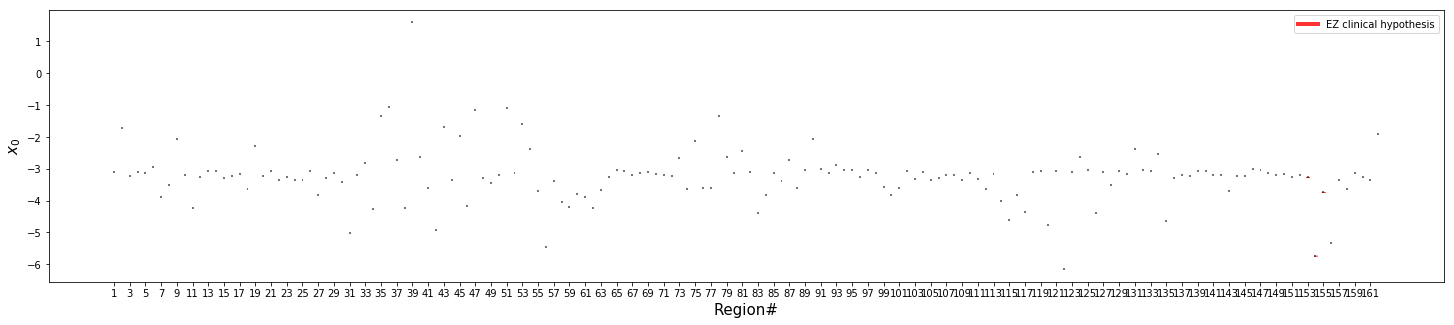

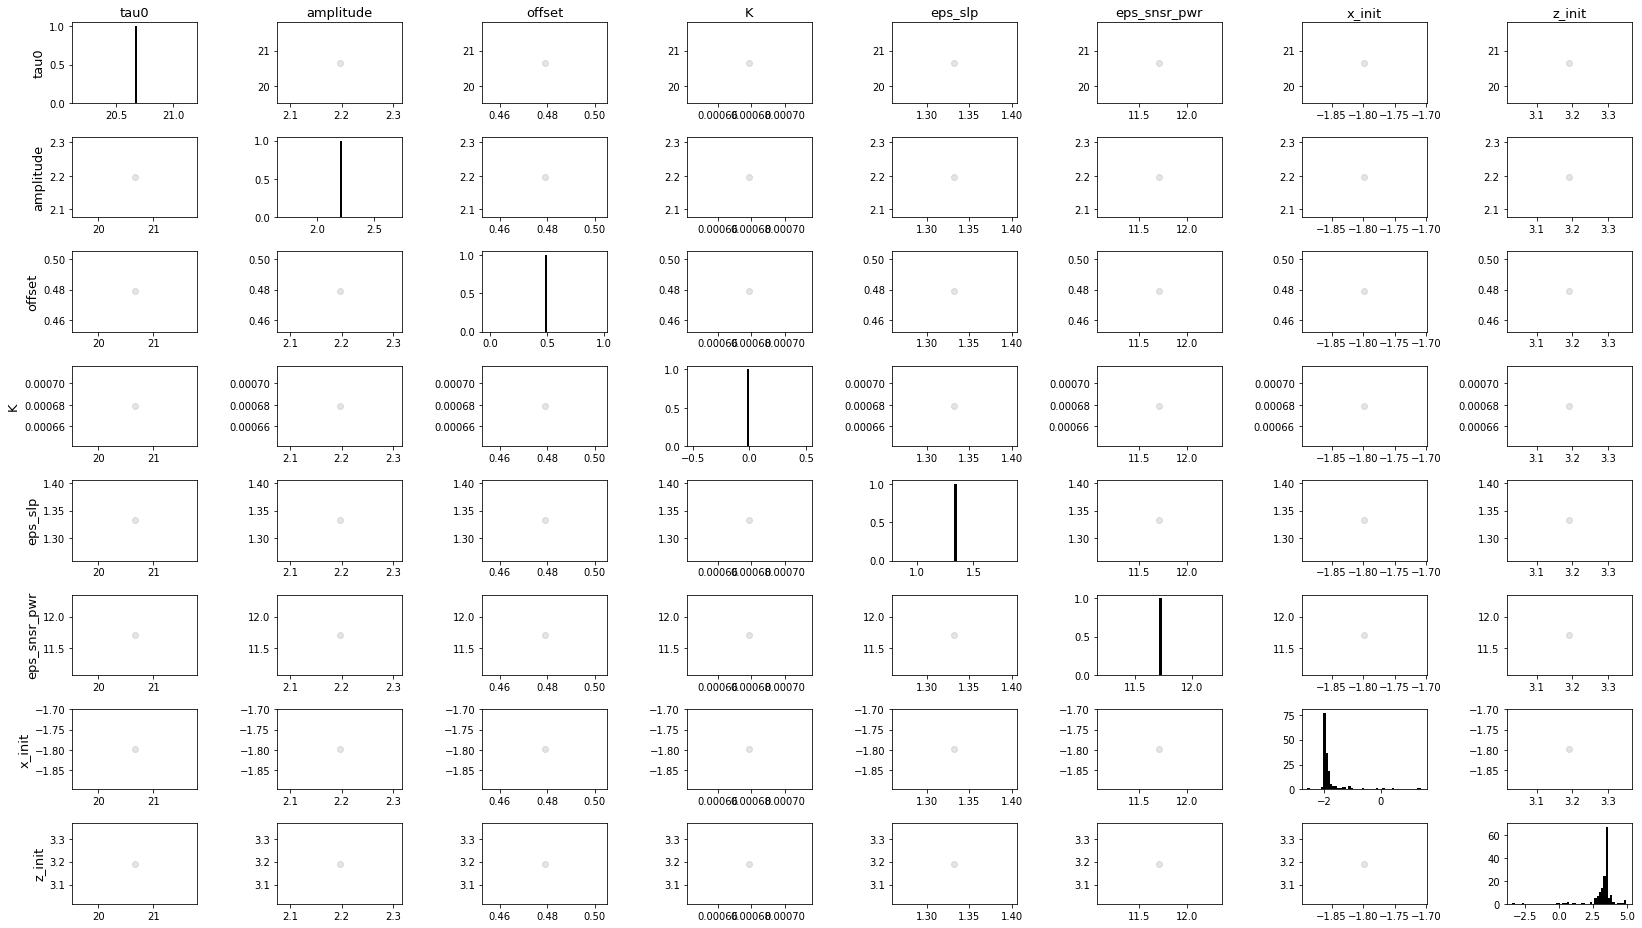

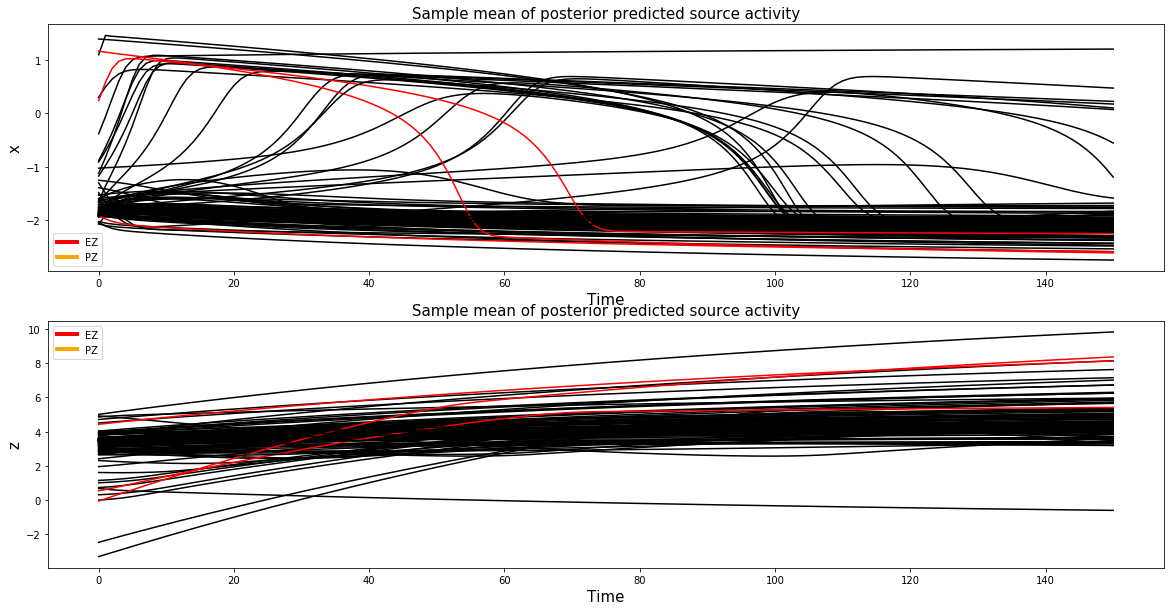

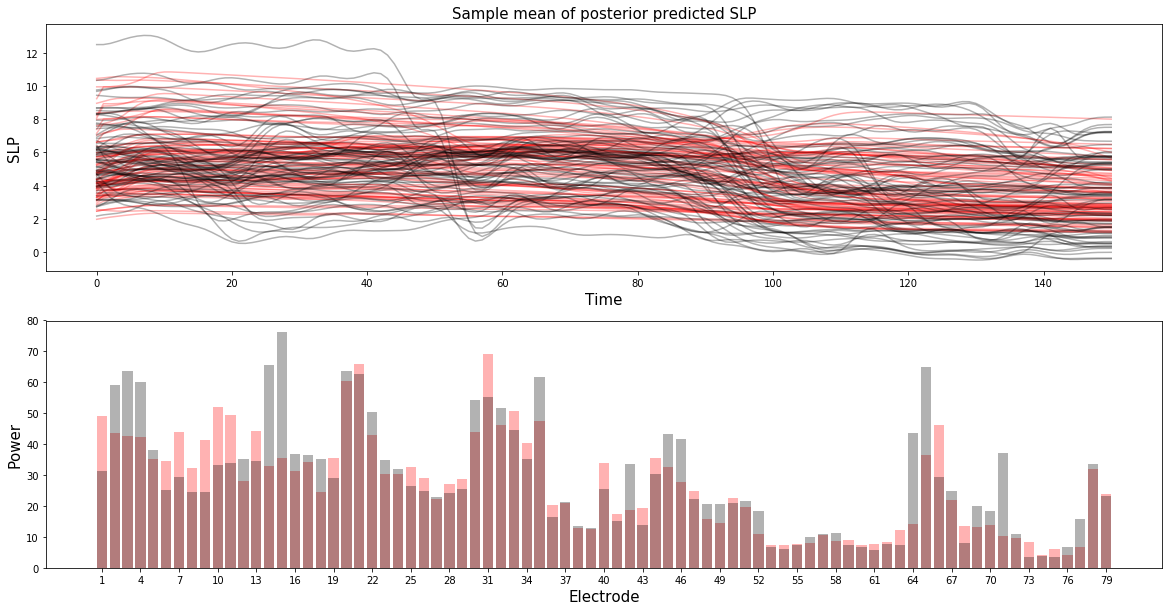

In [16]:
# import importlib
# importlib.reload(lib.plots.stan)

# ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.destrieux.txt') == 1)[0]
chains = [1,2,3,4]
for i,chain_no in enumerate(chains):
    pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{chain_no}.csv'])
    lib.plots.stan.x0_violin_patient(pstr_samples['x0'], ez_hyp, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}_chain{chain_no}.png')
    lib.plots.stan.pair_plots(pstr_samples, ['tau0', 'amplitude', 'offset', 'K', 'eps_slp', 'eps_snsr_pwr', 'x_init', 'z_init'],
                              figname=f'{results_dir}/figures/params_pair_plots_{fname_suffix}_chain{chain_no}.png')
    lib.plots.stan.plot_source(pstr_samples['x'].mean(axis=0), pstr_samples['z'].mean(axis=0), ez_hyp, [],
                               figname=f'{results_dir}/figures/posterior_predicted_src_{fname_suffix}_chain{chain_no}.png')
    lib.plots.stan.plot_fit_target({'slp':pstr_samples['mu_slp'].mean(axis=0), 'snsr_pwr':pstr_samples['mu_snsr_pwr'].mean(axis=0)},
                                   data, figname=f'{results_dir}/figures/posterior_predicted_slp_{fname_suffix}_chain{chain_no}.png')

